In [1]:
import muon as mu
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Data loading https://data.pyg.org/whl/torch-2.2.0+cu121.html

# T commit scCITE-seq data: "../data/t_commit.h5mu"
# totalVI SNL_111: "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/SNL_111.h5mu"
# 10X scCITE-seq data: "../data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5"
# Stereo CITE-seq data: "/home/wuxinchao/data/st_cite_data/sp_mudata.h5mu" B01825A4
# spatial_cite-seq data: "/home/wuxinchao/data/st_cite_data/spatial_cite_data"
!ls -l /home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/

总用量 1622404
drwxr-xr-x 4 wuxinchao BGI      4096 12月 12 14:11 data_filtering_scripts
-rw-r--r-- 1 wuxinchao BGI  21202281 12月 12 14:11 malt_10k_protein_v3.h5ad
drwxr-xr-x 5 wuxinchao BGI      4096 12月 12 14:11 metadata
-rw-r--r-- 1 wuxinchao BGI  24937137 12月 12 14:11 pbmc_10k_protein_v3.h5ad
-rw-r--r-- 1 wuxinchao BGI  18294964 12月 12 14:11 pbmc_5k_protein_v3.h5ad
drwxr-xr-x 2 wuxinchao BGI      4096 12月 12 14:11 raw_data
-rw-r--r-- 1 wuxinchao BGI       232 12月 12 14:11 README.md
-rw-r--r-- 1 wuxinchao BGI 928520340  2月  5 20:41 SLN_111.h5mu
-rw-r--r-- 1 wuxinchao BGI 468701906 12月 13 15:38 SNL_111.h5mu
-rw-r--r-- 1 wuxinchao BGI 100264418 12月 12 14:11 spleen_lymph_111.h5ad
-rw-r--r-- 1 wuxinchao BGI  99369558 12月 12 14:11 spleen_lymph_206.h5ad


In [5]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
SNL_206_adata = ad.read(f"{save_path}/spleen_lymph_206.h5ad")

In [3]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
SLN_adata = ad.read(save_path + "spleen_lymph_111.h5ad")

In [4]:
spatial_cite_data_path = "/home/wuxinchao/data/st_cite_data/sp_mudata.h5mu"

In [5]:
# sc_cite_mudata = mu.read_h5mu(sc_cite_seq_data_path)
spatial_cite_mudata = mu.read_h5mu(spatial_cite_data_path)

In [6]:
# align the features of two datasets
# pre-train the model using scCITE-seq data
# fine-tune the model using spatial CITE-seq data
# objective is to infer the missing protein and RNA expression in spatial CITE-seq data compared to scCITE-seq data
SNL_206_adata

AnnData object with n_obs × n_vars = 15820 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'
    uns: 'protein_names', 'version'
    obsm: 'protein_expression'

In [ ]:
def generate_h5mu_from_h5ad(adata):
    keep_prot = np.array(
    [not p.startswith("HTO") for p in adata.uns["protein_names"]]
    )
    adata.obsm["protein_expression"] = adata.obsm["protein_expression"][
        :, keep_prot
    ]
    adata.uns["protein_names"] = adata.uns["protein_names"][keep_prot]

# 1. Preprocess the data

In [8]:
SNL_206_adata.uns

OverloadedDict, wrapping:
	{'protein_names': array(['ADT_4-1BBLigand(CD137L)_A0890', 'ADT_CD102_A0104',
       'ADT_CD103_A0201', 'ADT_CD105_A0812', 'ADT_CD106_A0226',
       'ADT_CD107a(LAMP-1)_A0905', 'ADT_CD115(CSF-1R)_A0105',
       'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595', 'ADT_CD11b_A0014',
       'ADT_CD11c_A0106', 'ADT_CD120b(TNFRTypeII-p75)_A0893',
       'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD124(IL-4Ra)_A0916',
       'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195',
       'ADT_CD135_A0098', 'ADT_CD137_A0194',
       'ADT_CD138(Syndecan-1)_A0810', 'ADT_CD14_A0424',
       'ADT_CD140a_A0573', 'ADT_CD15(SSEA-1)_A0076',
       'ADT_CD150(SLAM)_A0203', 'ADT_CD152_A0388', 'ADT_CD155(PVR)_A1011',
       'ADT_CD159a(NKG2AB6)_A0927', 'ADT_CD16-32_A0109',
       'ADT_CD160_A1006', 'ADT_CD163_A0417', 'ADT_CD169(Siglec-1)_A0440',
       'ADT_CD170(Singlec-F)_A0431', 'ADT_CD172a(SIRPa)_A0422',
       'ADT_CD178(FasL)_A1012', 'ADT_CD182(CXCR2)_A0909',
       'ADT_CD183(CXCR3)_A0228', '

In [8]:
# filter the protein expression
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in SLN_adata.uns["protein_names"]]
)
SLN_adata.obsm["protein_expression"] = SLN_adata.obsm["protein_expression"][
    :, keep_pro_111
]
SLN_adata.uns["protein_names"] = SLN_adata.uns["protein_names"][keep_pro_111]
# # filter the RNA expression
# hvg_111 = SLN_adata.var["hvg_encode"]
# dataset = SLN_adata[:, hvg_111]

In [9]:
rna_data_111 = ad.AnnData(
    X=SLN_adata.X,
    obs=pd.DataFrame(index=SLN_adata.obs.index),
    var=pd.DataFrame(index=SLN_adata.var.index),
)

In [10]:
# rna_data_111.var_names_make_unique()
sc.pp.filter_cells(rna_data_111, min_genes=200)
sc.pp.filter_genes(rna_data_111, min_cells=3)
# annotate the group of mitochondrial genes as 'mt'
rna_data_111.var['mt'] = rna_data_111.var_names.str.startswith('mt-')  
sc.pp.calculate_qc_metrics(rna_data_111, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

In [11]:
len(set(rna_data_111.var_names))

13553

In [12]:
rna_data_111.layers["counts"] = rna_data_111.X.copy()

In [13]:
rna_data_111 = rna_data_111[rna_data_111.obs.n_genes_by_counts < 5000, :]
sc.pp.normalize_total(rna_data_111, target_sum=1e4)
sc.pp.log1p(rna_data_111)
sc.pp.scale(rna_data_111, max_value=10)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


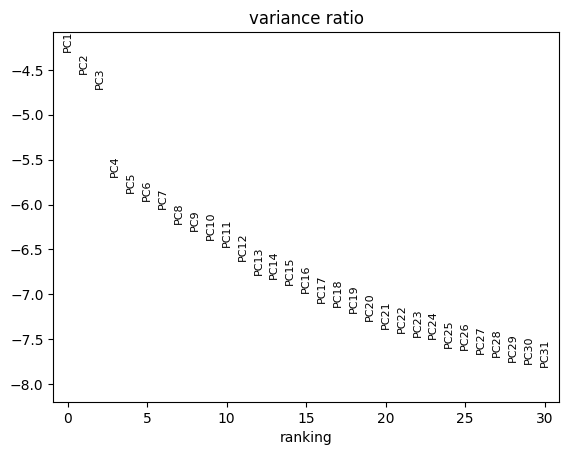

In [14]:
sc.tl.pca(rna_data_111, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna_data_111, log=True)

In [15]:
sc.pp.neighbors(rna_data_111, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna_data_111)

In [16]:
sc.tl.leiden(rna_data_111)

In [17]:
complete_metadata = pd.merge(rna_data_111.obs, SLN_adata.obs, left_index=True, right_index=True)

In [18]:
rna_data_111.obs = complete_metadata

In [19]:
protein_data_111 = ad.AnnData(
    X=np.array(SLN_adata.obsm["protein_expression"]),
    obs=SLN_adata.obs.copy(),
    var=SLN_adata.uns["protein_names"].copy()
)
protein_data_111.var_names = SLN_adata.uns["protein_names"]
protein_data_111.var = protein_data_111.var.drop(columns=0)

In [20]:
reassign_cluster_names = {
    "Neutrophils": "Myeloid",
    "Plasma B": "B",
    "Red-pulp macrophages": "Myeloid",
    "T doublets": "doublets",
    "Transitional B": "B",
    "Tregs": "Treg",
    "cDC1s": "DCs",
    "cDC2s": "DCs",
    "pDCs": "DCs",
    "B doublets": "doublets",
    "B-CD4 T cell doublets": "doublets",
    "B-CD8 T cell doublets": "doublets",
    "B-macrophage doublets": "doublets",
    "B1 B": "B",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Cycling B/T cells": "doublets",
    "Erythrocytes": "Erythrocytes",
    "GD T": "T",
    "ICOS-high Tregs": "Treg",
    "Activated CD4 T": "CD4 T",
    "Ifit3-high B": "B",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Low quality B cells": "Low quality B",
    "Low quality T cells": "Low quality T",
    "Ly6-high mono": "Myeloid",
    "Ly6-low mono": "Myeloid",
    "MZ B": "B",
    "MZ/Marco-high macrophages": "Myeloid",
    "Mature B": "B",
    "Migratory DCs": "DCs",
    "NK": "NK",
    "NKT": "NKT",
}

In [21]:
rna_data_111.obs["combined_cell_types"] = rna_data_111.obs["cell_types"].map(reassign_cluster_names)

In [22]:
rna_data_111.obs["batch_indices"]

index
AAACCCAAGGGTAATT-1    0
AAACCCAAGGTAAACT-1    0
AAACCCACACTAGGTT-1    0
AAACCCACAGATACCT-1    0
AAACCCACAGGAATAT-1    0
                     ..
TTTGTTGGTAAGATCA-2    1
TTTGTTGGTCAGACTT-2    1
TTTGTTGGTGTTTACG-2    1
TTTGTTGTCAGAATAG-2    1
TTTGTTGTCGAGTGGA-2    1
Name: batch_indices, Length: 16814, dtype: int64

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


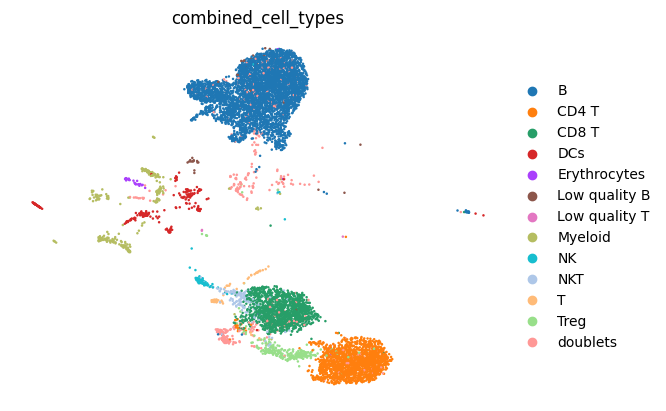

In [23]:
sc.pl.embedding(
    rna_data_111[rna_data_111.obs["batch_indices"] == 0],
    basis="X_umap",
    layer="rna_denoised",
    color=["combined_cell_types"],
    frameon=False,
    ncols=1,
)

In [24]:
mdata = mu.MuData({
    "rna": rna_data_111,
    "protein": protein_data_111,
})
mdata

MuData object with n_obs × n_vars = 16828 × 13663
  2 modalities
    rna:	16814 x 13553
      obs:	'n_genes_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes_y', 'percent_mito', 'leiden_subclusters', 'cell_types', 'combined_cell_types'
      var:	'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
      uns:	'log1p', 'pca', 'neighbors', 'umap', 'leiden'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    protein:	16828 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'

In [25]:
mdata.write_h5mu(save_path + "SLN_111.h5mu")

# 2. Align the features of two datasets
Find the common features of two datasets  
Integrate the two batches of data through the GSPI

The objective is to integrate the batches of datasets that cells labeled with the same cell type are close to each other in the embedding space.

The metrics should be used to evaluate the centrality of the cells and their neighbors in the embedding space.

In [117]:
import torch
import muon as mu
import scanpy as sc
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
mdata = mu.read_h5mu(save_path + "SLN_111.h5mu")
rna_adata = sc.read_h5ad(save_path + "rna_SNL_111.h5ad")
mdata, rna_adata

(MuData object with n_obs × n_vars = 16814 × 13658
   2 modalities
     rna:	16814 x 13548
       obs:	'n_genes_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes_y', 'percent_mito', 'leiden_subclusters', 'cell_types', 'combined_cell_types'
       var:	'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
       uns:	'leiden', 'log1p', 'neighbors', 'pca', 'umap'
       obsm:	'X_pca', 'X_umap'
       varm:	'PCs'
       layers:	'counts'
       obsp:	'connectivities', 'distances'
     protein:	16814 x 110
       obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types',
 AnnData object with n_obs × n_vars = 16814 × 13553
     obs: 'n_genes_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 

## Find HVG

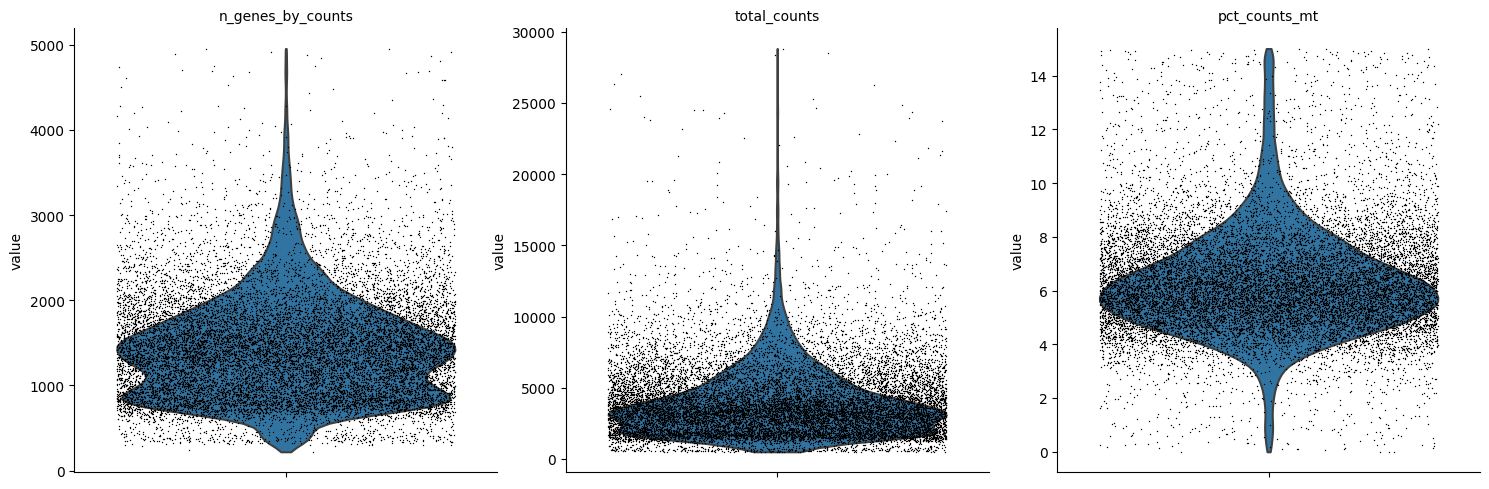

In [118]:
sc.pl.violin(rna_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
# sc.pl.highly_variable_genes(rna_adata)

In [119]:
mu.pp.filter_obs(rna_adata, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# Same as the following but doesn't copy the object
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]

mu.pp.filter_obs(rna_adata, 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(rna_adata, 'pct_counts_mt', lambda x: x < 15)

In [124]:
# sc.pp.normalize_total(rna_adata, target_sum=1e4)
# sc.pp.log1p(rna_adata)
rna_adata.X

array([[-0.50325346, -0.35508788,  0.4525279 , ..., -0.0684688 ,
        -0.3527349 , -0.04156548],
       [-0.50325346, -0.35508788, -0.58668953, ...,  0.41929564,
        -0.3527349 , -0.04156548],
       [-0.50325346, -0.35508788, -0.58668953, ...,  0.79163945,
        -0.3527349 , -0.04156548],
       ...,
       [-0.50325346, -0.35508788,  1.6990619 , ..., -1.1406796 ,
        -0.3527349 , -0.04156548],
       [-0.50325346, -0.35508788, -0.58668953, ..., -1.1406796 ,
        -0.3527349 , -0.04156548],
       [-0.50325346, -0.35508788, -0.58668953, ..., -1.1406796 ,
        -0.3527349 , -0.04156548]], dtype=float32)

In [121]:
sc.pp.highly_variable_genes(rna_adata, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna_adata)

KeyError: 'base'

In [14]:
# gene_dict = {
#     "Atn1-1": "Atn1",
#     "Dancr-1": "Dancr",
#     "Gbp6-1": "Gbp6",
#     "Hist2h2bb-1": "Hist2h2bb",
#     "Itgam-1": "Itgam",
#     "Pcdhga8-1": "Pcdhga8",
#     "Smim20-1": "Smim20",
#     "U2af1l4-1": "U2af1l4",
# }

In [15]:
# rna_adata = mdata.mod["rna"]

# # replace var_names using gene_dict
# for k, v in gene_dict.items():
#     rna_adata.var_names = rna_adata.var_names.str.replace(k, v)

In [16]:
# find the repeated gene names and only keep the first one
gene_names = mdata.mod['rna'].var_names
gene_names = pd.Series(gene_names)
# gene_names[gene_names.duplicated(keep=False)]
gene_names = gene_names[~gene_names.duplicated(keep='first')]
gene_names

0                Mrpl15
1                Lypla1
2                 Tcea1
3               Atp6v1h
4                Rb1cc1
              ...      
13548        AC125149.3
13549        AC168977.1
13550              PISD
13551             DHRSX
13552    CAAA01147332.1
Name: index, Length: 13548, dtype: object

In [17]:
mdata.mod['rna'] = mdata.mod['rna'][:, gene_names.index]

In [25]:
mdata.mod['protein'] = mdata.mod['protein'][mdata.mod['rna'].obs_names, :]

In [26]:
sc_mudata = mu.MuData({"rna": mdata.mod['rna'], "protein": mdata.mod['protein']})
sc_mudata.write_h5mu(save_path + "SLN_111.h5mu")
# mdata.write_h5mu(save_path + "SLN_111.h5mu")

# Training

In [1]:
import numpy as np
import pandas as pd
import torch
import muon as mu
import matplotlib.pyplot as plt
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
mdata = mu.read_h5mu(save_path + "SLN_111.h5mu")

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gtf_path = "/DATA/User/wuxinchao/st_cite_data/ref/Mus_musculus.GRCm38.84.gtf"
geneVocab = GeneVocab(mdata.mod['rna'])
geneVocab.sort_by_genomic_position(gtf_path)
sc_rna_data = geneVocab.align_features(mdata.mod['rna'])
sc_prot_data = mdata.mod['protein'][mdata.mod['rna'].obs_names]
sc_rna_data.obsp = mdata.mod['rna'].obsp
# sc_prot_data.var_names = sc_prot_data.var_names.str.split("_").str[-2]

In [3]:
model_choice = "Graph Cross Attention"

rna_input_dim = mdata.mod['rna'].X.shape[1]
prot_input_dim = mdata.mod['protein'].X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 50
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

scData = SinglecellData(mdata, geneVocab)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData.data)

/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/dataset.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()


In [30]:
rna_input_dim

13548

In [5]:
from train import Trainer
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/50 train_loss: 334927.47827 val_loss: 71803.17017
Epoch 2/50 train_loss: 194175.92163 val_loss: 52979.18787
Epoch 3/50 train_loss: 117335.91449 val_loss: 37255.92114
Epoch 4/50 train_loss: 105371.17255 val_loss: 36015.49365
Epoch 5/50 train_loss: 100414.17822 val_loss: 32268.77747
Epoch 6/50 train_loss: 84610.43073 val_loss: 27801.93890
Epoch 7/50 train_loss: 75301.79553 val_loss: 25798.01971
Epoch 8/50 train_loss: 69590.80176 val_loss: 24289.42664
Epoch 9/50 train_loss: 61964.45880 val_loss: 22231.84247
Epoch 10/50 train_loss: 53644.54315 val_loss: 19487.02393
Epoch 11/50 train_loss: 49969.44870 val_loss: 19253.66226
Epoch 12/50 train_loss: 47226.71512 val_loss: 18443.59073
Epoch 13/50 train_loss: 43896.04523 val_loss: 17068.76218
Epoch 14/50 train_loss: 41596.58160 val_loss: 16903.71368
Epoch 15/50 train_loss: 39779.74814 val_loss: 16055.01453
Epoch 16/50 train_loss: 38327.93808 val_loss: 16041.51505
Epoch 17/50 train_loss: 36162.34308 val_loss: 15288.15121
Epoch 18/50 train_

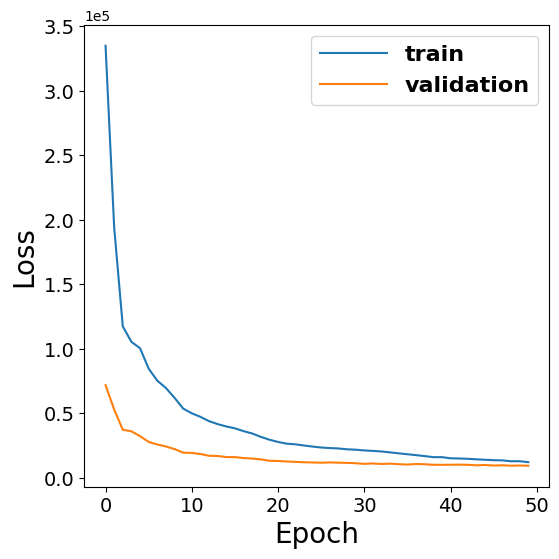

In [25]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'bold'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("scCITE_training_loss.png")

In [26]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_best_model.pt")

# 3. Transfer the scCITE-seq data to spCITE-seq data

What should be done to the spatial data?

1. Impute the missing values and infer the real values for the spatial data?
2. Impute the missing protein values and infer the real values for the spatial data?
3. Check the embedding space of the spatial data and the scCITE-seq data, and find the corresponding cells in the embedding space that are close to each other.

In [4]:
sp_data_path = "/home/wuxinchao/data/st_cite_data/"
sp_mudata = mu.read_h5mu(sp_data_path + "sp_mudata.h5mu")
rna_adata = sp_mudata.mod["rna"]
prot_adata = sp_mudata.mod["prot"]

In [5]:
rna_adata = geneVocab.align_features(rna_adata)

/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/dataset.py:86: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_new = ad.AnnData(adata_new_df.values, obs=adata.obs, var=adata_new_var_df)


In [6]:
sp_mudata.mod['prot'].var_names = sp_mudata.mod['prot'].var_names.str.split("_").str[-2]
prot_names_map = {
    "CD3": "TCRbchain",
    "2": "CD90.2",
}
# sp_mudata.mod['prot'].var_names = sp_mudata.mod['prot'].var_names.str.map(prot_names_map)

In [7]:
# sp_mudata.mod['prot'].var_names.map(prot_names_map)
# for k, v in prot_names_map.items():
#     sp_mudata.mod['prot'].var_names = sp_mudata.mod['prot'].var_names.str.replace(k, v)
prot_adata.var_names = prot_adata.var_names.str.replace("CD3", "TCRbchain")
# limit the str replace to the full match
prot_adata.var_names = prot_adata.var_names.str.replace(r"\b2\b", "CD90.2")

/tmp/ipykernel_2654624/209193205.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  prot_adata.var_names = prot_adata.var_names.str.replace(r"\b2\b", "CD90.2")


In [8]:
# align the protein features of spatial CITE-seq data with scCITE-seq data
intersect_proteins = np.intersect1d(sc_prot_data.var_names, prot_adata.var_names)
len(intersect_proteins)

0

In [9]:
prot_adata = prot_adata[:, intersect_proteins]
prot_adata

View of AnnData object with n_obs × n_vars = 8628 × 0
    obsm: 'spatial'

In [10]:
# create a new mtx to store the protein expression
prot_exp_mtx = np.zeros((prot_adata.shape[0], sc_prot_data.shape[1]))
# filling the missing protein expression with 0
for i, p in enumerate(sc_prot_data.var_names):
    if p in prot_adata.var_names:
        prot_exp_mtx[:, i] = prot_adata[:, p].X.toarray().flatten()
    else:
        prot_exp_mtx[:, i] = 0

In [11]:
# loading the pre-trained model
from model import GraphCrossAttn

model = GraphCrossAttn(
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
).to(device)

# load the pre-trained model
model.load_state_dict(torch.load("../save_model/best_model.pt")["model"])

<All keys matched successfully>

In [12]:
prot_exp_mtx.shape

(8628, 110)

In [13]:
# build Data for spatial CITE-seq data
adj_mtx = sp_mudata.mod['rna'].obsp['connectivities'].toarray()
edge_index = adj_mtx.nonzero()
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((rna_adata.X, prot_exp_mtx), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
sp_data = Data(x=concat_data, edge_index=edge_index)

In [14]:
from torch_geometric.loader import NeighborLoader, DataLoader

dataloader = NeighborLoader(
    sp_data,
    num_neighbors=[20] * 2,
    batch_size=128,
)

# dataloader_data = DataLoader(
#     sp_data,
#     batch_size=1,
# )
# one_data = next(iter(dataloader_data))
# dataloader_data.dataset

In [53]:
num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

sp_training_data = tsf(sp_data)

In [54]:
from train import Trainer
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    sp_training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=50,
    mask_ratio=0.75,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/50 train_loss: 9.79726 val_loss: 3.33341
Epoch 2/50 train_loss: 9.62340 val_loss: 3.32787
Epoch 3/50 train_loss: 9.60970 val_loss: 3.33447
Epoch 4/50 train_loss: 9.58881 val_loss: 3.31336
Epoch 42/50 train_loss: 9.47071 val_loss: 3.29106
Epoch 43/50 train_loss: 9.47415 val_loss: 3.28250
Epoch 44/50 train_loss: 9.44744 val_loss: 3.30282
Epoch 45/50 train_loss: 9.45377 val_loss: 3.29726
Epoch 46/50 train_loss: 9.46850 val_loss: 3.27786
Epoch 47/50 train_loss: 9.45667 val_loss: 3.28868
Epoch 48/50 train_loss: 9.44979 val_loss: 3.28160
Epoch 49/50 train_loss: 9.43921 val_loss: 3.28751
Epoch 50/50 train_loss: 9.44585 val_loss: 3.29213
Epoch 1/50 train_loss: 9.85713 val_loss: 3.32613
Epoch 2/50 train_loss: 9.65994 val_loss: 3.32368
Epoch 3/50 train_loss: 9.62055 val_loss: 3.30841
Epoch 5/50 train_loss: 9.54336 val_loss: 3.30345
Epoch 13/50 train_loss: 9.50572 val_loss: 3.27510
Epoch 14/50 train_loss: 9.49299 val_loss: 3.26816
Epoch 15/50 train_loss: 9.48661 val_loss: 3.28080
Epoch 16

In [ ]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/spCITE_seq_transfer.pt")

In [ ]:
model.load_state_dict(torch.load("../save_model/spCITE_seq_transfer.pt")["model"])

<All keys matched successfully>

In [70]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(sp_data)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [71]:
rna_recon.shape, prot_recon.shape, embedding.shape

((8628, 13548), (8628, 110), (8628, 32))

### MSE_per_gene

In [72]:
mse_per_gene = np.mean((rna_adata.X - rna_recon) ** 2, axis=0)
mse_per_gene.shape

(13548,)

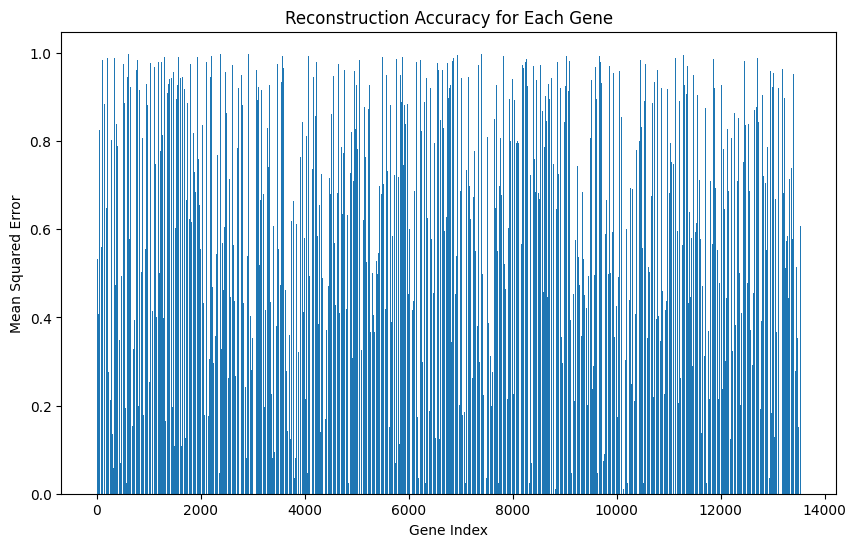

In [73]:
mse_per_gene = np.mean((rna_adata.X - rna_recon) ** 2, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(mse_per_gene)), mse_per_gene)
plt.xlabel('Gene Index')
plt.ylabel('Mean Squared Error')
plt.title('Reconstruction Accuracy for Each Gene')
plt.show()

In [74]:
num_genes = rna_adata.X.shape[1]
gene_names = rna_adata.var_names.to_list()
mean_errors = []

# Calculate mean error for each gene
for i in range(num_genes):
    mean_error = np.mean(np.abs(rna_adata.X[:, i] - rna_recon[:, i]))
    mean_errors.append(mean_error)

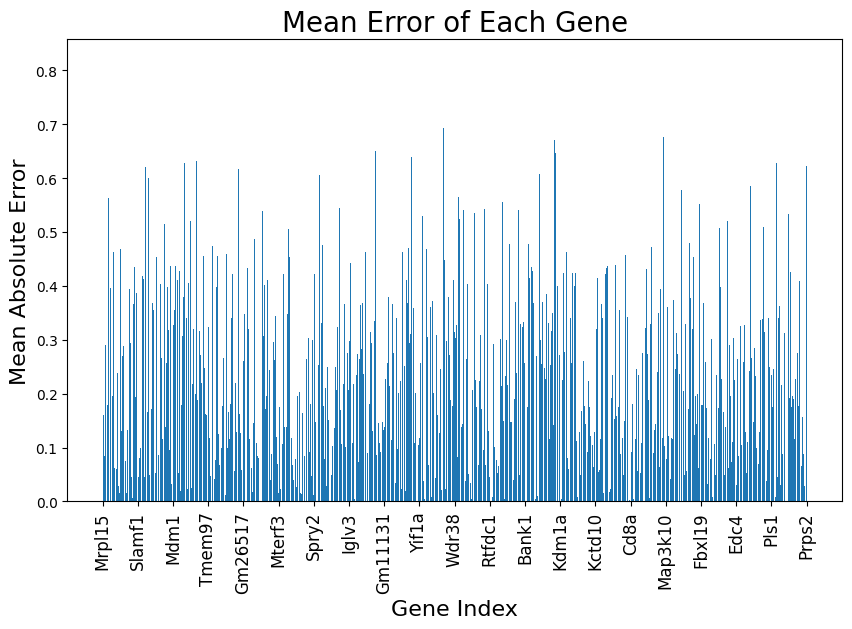

In [75]:
# Plot the mean errors for each gene
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_errors)), mean_errors)
plt.xlabel('Gene Index', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=16)
plt.title('Mean Error of Each Gene', fontsize=20)
# plt.xticks(range(len(mean_errors)), gene_names, rotation=90)
tick_interval = max(1, len(gene_names) // 20)  # Ensure at least one tick is shown
selected_ticks = range(0, len(gene_names), tick_interval)
selected_gene_names = [gene_names[i] for i in selected_ticks]
plt.xticks(selected_ticks, selected_gene_names, rotation=90, fontsize=12)
# plt.tight_layout()
plt.savefig("Thymus_mean_erro_of_gene.png")
plt.show()

### R-square for each gene

In [76]:
from sklearn.metrics import r2_score
import seaborn as sns
# Assuming original_data and reconstructed_data are numpy arrays of shape (num_genes, num_samples)
num_genes = rna_adata.X.shape[1]
r_squared_scores = []

# Calculate R-squared for each gene
for i in range(num_genes):
    r_squared = r2_score(rna_adata.X[:, i], rna_recon[:, i])
    r_squared_scores.append(r_squared)

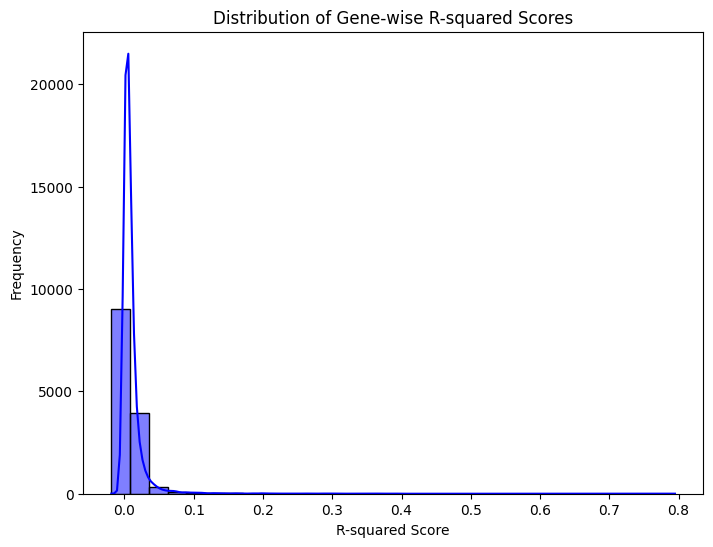

In [77]:
# Plot the distribution of R-squared scores
plt.figure(figsize=(8, 6))
sns.histplot(r_squared_scores, bins=30, kde=True, color='blue')
plt.xlabel('R-squared Score')
plt.ylabel('Frequency')
plt.title('Distribution of Gene-wise R-squared Scores')
plt.show()

### Using embedding for UMAP and clustering

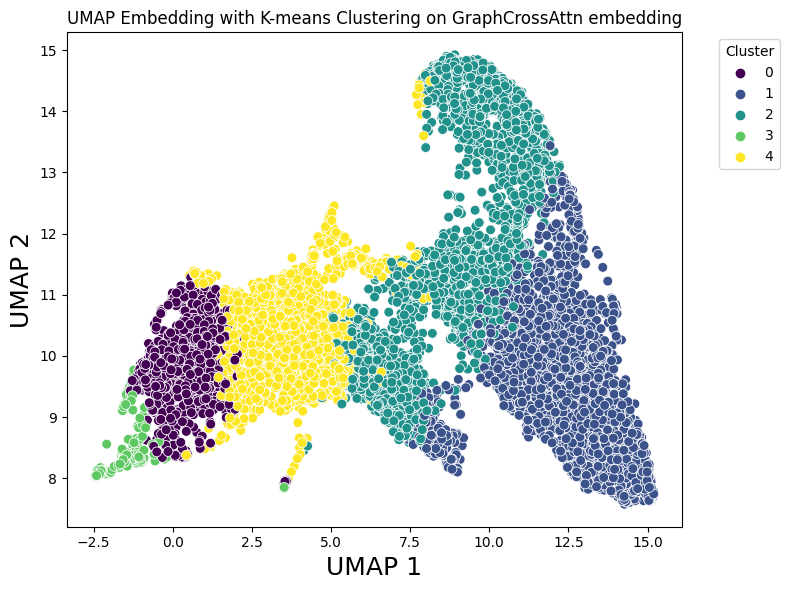

In [145]:
import umap
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'embedding' is a NumPy array containing your model's embedding
# with shape (num_samples, embedding_dim)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(embedding)

# Perform K-means clustering
n_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

# Plot UMAP embedding with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title('UMAP Embedding with K-means Clustering on GraphCrossAttn embedding')
plt.xlabel('UMAP 1', fontsize = 18)
plt.ylabel('UMAP 2', fontsize = 18)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Attention weights

In [79]:
model

GraphCrossAttn(
  (rna_embedding): Linear(13548, 32, bias=True)
  (prot_embedding): Linear(110, 32, bias=True)
  (cross_attn_blocks): ModuleList(
    (0-1): 2 x GraphAttnBlock(
      (conv1): GATConv((-1, -1), 32, heads=4)
      (lin1): Linear(64, 128, bias=True)
      (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (conv2): GATConv((-1, -1), 32, heads=4)
      (lin2): Linear(128, 128, bias=True)
    )
  )
  (cross_attn_agg): Linear(128, 32, bias=True)
  (rna_decoding): Linear(32, 32, bias=True)
  (prot_decoding): Linear(32, 32, bias=True)
  (rna_recon): Linear(32, 13548, bias=True)
  (prot_recon): Linear(32, 110, bias=True)
)

In [50]:
attention_scores = [block.conv1.attention_weights.cpu().numpy() for block in model.cross_attn_blocks]

AttributeError: 'GATConv' object has no attribute 'attention_weights'

In [ ]:
model.cross_attn_blocks[0].conv1

GATConv((-1, -1), 32, heads=4)

### Using HVG for integration

In [169]:
hvg_rna = sp_mudata.mod['rna']

In [175]:
hvg_rna.layers["counts"].sum(axis=1)

array([271.1819 , 312.25522, 317.30176, ...,   0.     ,   0.     ,
         0.     ], dtype=float32)

In [133]:
# build Data for spatial CITE-seq data
adj_mtx = sp_mudata.mod['rna'].obsp['connectivities'].toarray()
edge_index = adj_mtx.nonzero()
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((hvg_rna.X, prot_exp_mtx), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
sp_data = Data(x=concat_data, edge_index=edge_index)

In [135]:
rna_input_dim = hvg_rna.shape[1]

In [136]:
from torch_geometric.loader import NeighborLoader, DataLoader

dataloader = NeighborLoader(
    sp_data,
    num_neighbors=[20] * 2,
    batch_size=128,
)

# dataloader_data = DataLoader(
#     sp_data,
#     batch_size=1,
# )
# one_data = next(iter(dataloader_data))
# dataloader_data.dataset

In [137]:
num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

sp_training_data = tsf(sp_data)

In [138]:
from train import Trainer
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    sp_training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=50,
    mask_ratio=0.75,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/50 train_loss: 3.82753 val_loss: 1.33245
Epoch 2/50 train_loss: 3.62741 val_loss: 1.32854
Epoch 3/50 train_loss: 3.64364 val_loss: 1.33024
Epoch 4/50 train_loss: 3.62863 val_loss: 1.34143
Epoch 5/50 train_loss: 3.62685 val_loss: 1.32232
Epoch 6/50 train_loss: 3.64063 val_loss: 1.32903
Epoch 7/50 train_loss: 3.57459 val_loss: 1.32055
Epoch 8/50 train_loss: 3.57893 val_loss: 1.30780
Epoch 9/50 train_loss: 3.54397 val_loss: 1.29316
Epoch 10/50 train_loss: 3.53624 val_loss: 1.29169
Epoch 11/50 train_loss: 3.51678 val_loss: 1.27139
Epoch 12/50 train_loss: 3.51111 val_loss: 1.30909
Epoch 13/50 train_loss: 3.49963 val_loss: 1.29856
Epoch 14/50 train_loss: 3.51203 val_loss: 1.28868
Epoch 15/50 train_loss: 3.49995 val_loss: 1.28898
Epoch 16/50 train_loss: 3.51470 val_loss: 1.29318
Epoch 17/50 train_loss: 3.49064 val_loss: 1.30428
Epoch 18/50 train_loss: 3.52823 val_loss: 1.30123
Epoch 19/50 train_loss: 3.50504 val_loss: 1.28545
Epoch 20/50 train_loss: 3.47980 val_loss: 1.29288
Epoch 21/

In [141]:
model = trainer.best_model

In [142]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(sp_data)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [165]:
hvg_rna.X = hvg_rna.layers["counts"]

In [171]:
sc.pp.calculate_qc_metrics(hvg_rna)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


(        n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
 37_3                23792                10.077147  -1316.665039   
 23_65               23802                10.077567  -1091.813354   
 78_72               23799                10.077441   -992.938538   
 94_32               23838                10.079078    908.987915   
 42_4                23792                10.077147  -1317.702515   
 ...                   ...                      ...           ...   
 113_62              23778                10.076558  -2326.582520   
 113_70              23778                10.076558  -2326.582520   
 113_69              23778                10.076558  -2326.582520   
 112_78              23778                10.076558  -2326.582520   
 113_75              23778                10.076558  -2326.582520   
 
         log1p_total_counts  pct_counts_in_top_50_genes  \
 37_3                   NaN                  -37.974730   
 23_65                  NaN                  -45.318

In [168]:
hvg_rna.X

ArrayView([[1.6885753, 0.       , 0.       , ..., 0.       , 0.       ,
            1.6885753],
           [1.4081134, 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [1.3409257, 0.       , 0.       , ..., 0.       , 0.       ,
            1.3409257],
           ...,
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ]], dtype=float32)

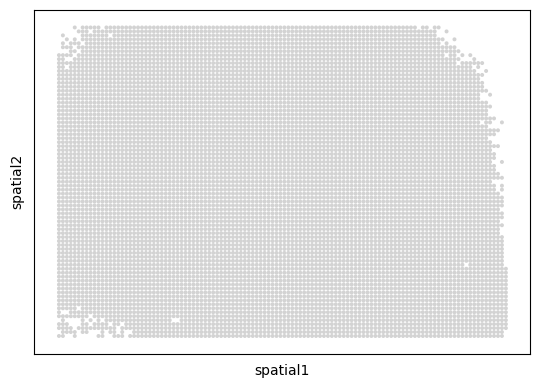

In [160]:
sc.pl.spatial(hvg_rna, spot_size=1)

# B02415A5

In [1]:
import muon as mu
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad

import torch
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## B01825A4 square bin mouse thymus stereo-CITE

In [4]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

In [5]:
data_path = "/home/wuxinchao/data/st_cite_data/B01825A4/"

In [7]:
mouse_thymus_rna_data = f"{data_path}B01825A4_RNA_mouse_thymus_bin100.h5ad"
mouse_thymus_prot_data = f"{data_path}B01825A4_Port_mouse_thymus_bin100.h5ad"
rna_adata = sc.read_h5ad(mouse_thymus_rna_data)
prot_adata = sc.read_h5ad(mouse_thymus_prot_data)
rna_adata, prot_adata

(AnnData object with n_obs × n_vars = 9091 × 25818
     obs: 'area'
     uns: '__type', 'pp', 'spatial'
     obsm: 'bbox', 'contour', 'spatial',
 AnnData object with n_obs × n_vars = 5664 × 199
     obs: 'area'
     uns: '__type', 'pp', 'spatial'
     obsm: 'bbox', 'contour', 'spatial')

### Preprocess

In [8]:
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

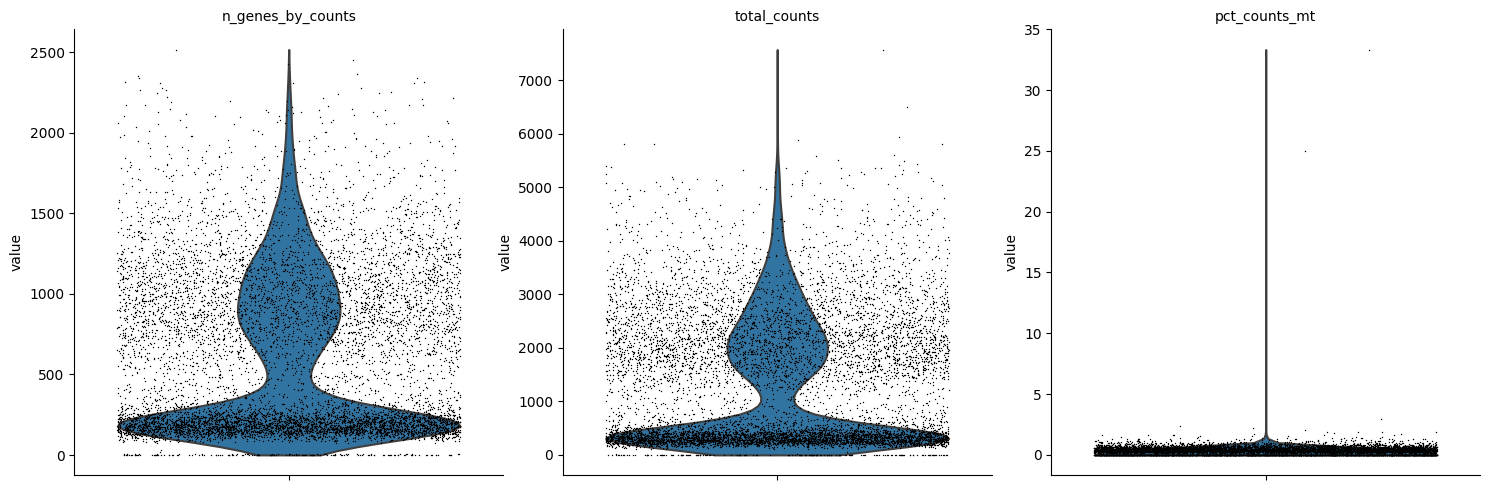

In [9]:
sc.pl.violin(rna_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts >100, :]
rna_adata = rna_adata[rna_adata.obs.total_counts > 500, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 15, :]
rna_adata

View of AnnData object with n_obs × n_vars = 4964 × 25818
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'pp', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'

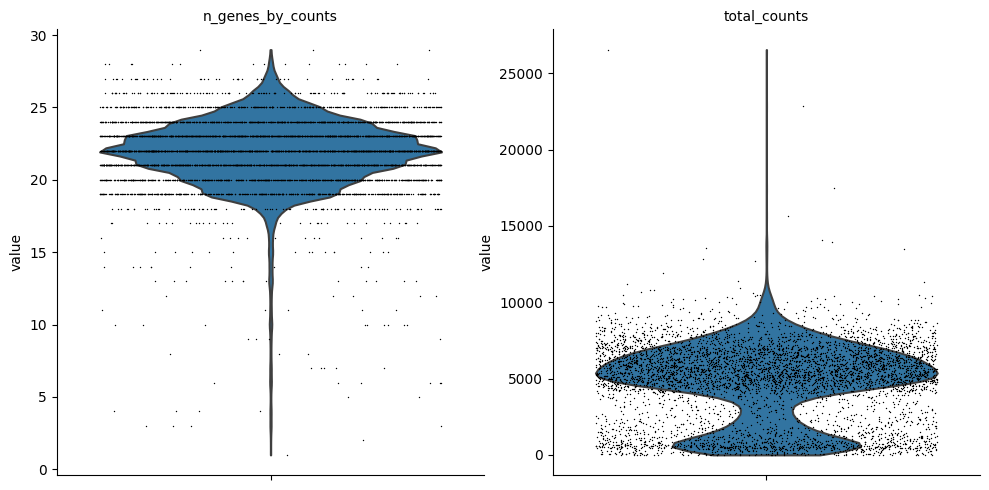

In [11]:
sc.pp.calculate_qc_metrics(prot_adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(prot_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [12]:
prot_adata = prot_adata[prot_adata.obs.n_genes_by_counts > 15, :]
prot_adata = prot_adata[prot_adata.obs.total_counts > 2000, :]
prot_adata

View of AnnData object with n_obs × n_vars = 4515 × 199
    obs: 'area', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'pp', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'

In [15]:
common_name = set(prot_adata.obs_names.to_list()).intersection(
                       set(rna_adata.obs_names.to_list()))

prot_adata = prot_adata[prot_adata.obs_names.isin(common_name), :]

In [16]:
common_name = set(rna_adata.obs_names.to_list()).intersection(
                       set(prot_adata.obs_names.to_list()))

rna_adata = rna_adata[rna_adata.obs_names.isin(common_name), :]

In [19]:
rna_adata.layers["counts"] = rna_adata.X.copy()

/tmp/ipykernel_1020671/936652316.py:1: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rna_adata.layers["counts"] = rna_adata.X.copy()


In [20]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)
# mouse_thymus_rna.obs_names_make_unique()

In [22]:
sc.pp.highly_variable_genes(
    rna_adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    # batch_key="batch_indices",
    layer="counts",
)

In [23]:
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_adata, resolution=.75)
sc.tl.umap(rna_adata, spread=1., min_dist=.5, random_state=42)

In [24]:
prot_adata.layers["counts"] = prot_adata.X.copy()
sc.pp.normalize_total(prot_adata, target_sum=1e4)
sc.pp.log1p(prot_adata)

/tmp/ipykernel_1020671/2869673127.py:1: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  prot_adata.layers["counts"] = prot_adata.X.copy()


In [25]:
mdata = mu.MuData({
    "rna": rna_adata,
    "protein": prot_adata
})

In [26]:
mdata.write(f"{data_path}B01825A4_bin100_processed.h5mu")

In [27]:
mdata

MuData object with n_obs × n_vars = 4499 × 26017
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	4499 x 25818
      obs:	'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'__type', 'pp', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
      obsm:	'bbox', 'contour', 'spatial', 'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    protein:	4499 x 199
      obs:	'area', 'n_genes_by_counts', 'total_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'__type', 'pp', 'spatial', 'log1p'
      obsm:	'bbox', 'contour', 'spatial'
      layers:	'counts'

### training on transfer

In [28]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"

In [29]:
scCITE_mdata = mu.read_h5mu(f"{save_path}scCITE_intersect.h5mu")
scCITE_mdata

MuData object with n_obs × n_vars = 32648 × 13658
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

In [35]:
# highly_variable = pd.read_csv(f"{save_path}/scCITE_hvg.csv")
highly_variable_genes = scCITE_mdata['rna'].var_names[scCITE_mdata['rna'].var['highly_variable']].to_list()

In [37]:
# rna_adata[:,highly_variable.iloc[:,0]]
rna_adata_hvg_transfer = rna_adata[:, rna_adata.var_names.isin(highly_variable_genes)]
rna_adata_hvg_transfer

View of AnnData object with n_obs × n_vars = 4499 × 3852
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '__type', 'pp', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'bbox', 'contour', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [41]:
highly_variable = pd.DataFrame(columns=highly_variable_genes)
tmp_exp = rna_adata_hvg_transfer.X.A
for i, gene_name in enumerate(rna_adata_hvg_transfer.var_names):
    highly_variable[gene_name] = tmp_exp[:,i]
    if i % 10==0:
        print(i)
highly_variable = highly_variable.fillna(0)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [42]:
list1 = [i[:-1] for i in scCITE_mdata["protein"].var_names.str.replace("ADT_","").str.split("_")]
list2 = prot_adata.var_names.to_list()
result = {}
for i, protein1 in enumerate(list1):
    for j, protein2 in enumerate(list2):
        if ''.join(filter(str.isalnum, protein1[0].lower())) in ''.join(filter(str.isalnum, protein2.lower())):
            result[protein1[0]] = [i, j]
            break
            
result

{'CD102': [0, 107],
 'CD103': [1, 1],
 'CD106': [2, 109],
 'CD115(CSF-1R)': [3, 13],
 'CD11a': [5, 111],
 'CD11c': [6, 16],
 'CD127(IL-7Ra)': [8, 18],
 'CD134(OX-40)': [9, 21],
 'CD14': [12, 23],
 'CD150(SLAM)': [15, 25],
 'CD16-32': [16, 122],
 'CD169(Siglec-1)': [17, 121],
 'CD172a(SIRPa)': [18, 32],
 'CD19': [21, 34],
 'CD192(CCR2)': [22, 35],
 'CD195(CCR5)': [23, 37],
 'CD196(CCR6)': [24, 38],
 'CD20': [26, 41],
 'CD200(OX2)': [27, 128],
 'CD21-CD35(CR2-CR1)': [31, 130],
 'CD223(LAG-3)': [32, 44],
 'CD23': [33, 133],
 'CD24': [34, 46],
 'CD274(B7-H1': [36, 52],
 'CD279(PD-1)': [38, 54],
 'CD29': [40, 195],
 'CD304(Neuropilin-1)': [44, 56],
 'CD335(NKp46)': [46, 142],
 'CD357(GITR)': [47, 144],
 'CD36': [48, 64],
 'CD366(Tim-3)': [49, 145],
 'CD4': [52, 66],
 'CD41': [53, 68],
 'CD43': [54, 148],
 'CD45': [55, 69],
 'CD45.2': [57, 150],
 'CD45R-B220': [58, 194],
 'CD48': [59, 71],
 'CD49d': [60, 153],
 'CD5': [61, 74],
 'CD54': [62, 74],
 'CD55(DAF)': [63, 157],
 'CD62L': [64, 78],


In [43]:
len(result)

67

In [45]:
new_prot_exp = pd.DataFrame(columns = scCITE_mdata["protein"].var_names)
for protein in result:
    new_prot_exp[new_prot_exp.columns[result[protein][0]]] = prot_adata.X.A[:, result[protein][1]]
new_prot_exp = new_prot_exp.fillna(0)

In [49]:
# new_prot_exp, highly_variable

In [88]:
from utils import build_adjacency_matrix_torch

model_choice = "Graph Cross Attention"

rna_input_dim = highly_variable.shape[1]
prot_input_dim = new_prot_exp.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_hvg_transfer.obsm["spatial"], T=0, alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((highly_variable.values, new_prot_exp.values), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 1
num_val = 0.4
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [89]:
# loading the pre-trained model
from model import GraphCrossAttn

model = GraphCrossAttn(
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
).to(device)

# load the pre-trained model
# model.load_state_dict(torch.load("../save_model/scCITE_intersect_hvg.pt")["model"])

In [90]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.85,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses = trainer.fine_tune(model=model, epochs=10, 
                    model_name="scCITE_intersect_hvg.pt", save_name="sc_stereo_CITE_spleen_bin100_transfer.pt")

Epoch 1/10, Loss: 1.5890561118721962
Epoch 2/10, Loss: 0.41322161816060543
Epoch 3/10, Loss: 0.15362939052283764
Epoch 4/10, Loss: 0.124761744402349
Epoch 5/10, Loss: 0.0987492622807622
Epoch 6/10, Loss: 0.08999224659055471
Epoch 7/10, Loss: 0.08573229238390923
Epoch 8/10, Loss: 0.08407229464501143
Epoch 9/10, Loss: 0.08296460006386042
Epoch 10/10, Loss: 0.08279072586447


In [91]:
model.load_state_dict(torch.load("../save_model/best_sc_stereo_CITE_spleen_bin100_transfer.pt")["model"])

<All keys matched successfully>

In [92]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [96]:
np.save("../data/GraphCrossRNArecon_mouse_thymus_stereoCITE_bin100_integrate_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_mouse_thymus_stereoCITE_bin100_integrate_hvg.npy", prot_recon)
np.save("../data/GraphCrossEmbedding_mouse_thymus_stereoCITE_bin100_integrate_hvg.npy", embedding)

### sp integrate

In [65]:
rna_adata_subset = rna_adata[:, rna_adata.var["highly_variable"]]

In [69]:
rna_adata_subset.X

<4499x4000 sparse matrix of type '<class 'numpy.float32'>'
	with 578897 stored elements in Compressed Sparse Row format>

In [97]:
from utils import build_adjacency_matrix_torch

model_choice = "Graph Cross Attention"

rna_input_dim = rna_adata_subset.shape[1]
prot_input_dim = prot_adata.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_subset.obsm["spatial"], T=0, alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_adata_subset.X.A, prot_adata.X.A), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.4
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [98]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.85,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 14.18699 val_loss: 13.44750
Epoch 2/20 train_loss: 12.39722 val_loss: 10.40530
Epoch 3/20 train_loss: 8.17764 val_loss: 5.29258
Epoch 4/20 train_loss: 3.62001 val_loss: 1.93852
Epoch 5/20 train_loss: 1.35101 val_loss: 0.87246
Epoch 6/20 train_loss: 0.79444 val_loss: 0.69846
Epoch 7/20 train_loss: 0.64658 val_loss: 0.58026
Epoch 8/20 train_loss: 0.55212 val_loss: 0.51890
Epoch 9/20 train_loss: 0.51311 val_loss: 0.49443
Epoch 10/20 train_loss: 0.48636 val_loss: 0.47050
Epoch 11/20 train_loss: 0.46399 val_loss: 0.45836
Epoch 12/20 train_loss: 0.45248 val_loss: 0.44942
Epoch 13/20 train_loss: 0.44734 val_loss: 0.44648
Epoch 14/20 train_loss: 0.44008 val_loss: 0.45122
Epoch 15/20 train_loss: 0.44127 val_loss: 0.46355
Epoch 16/20 train_loss: 0.44490 val_loss: 0.48350
Epoch 17/20 train_loss: 0.45083 val_loss: 0.51785
Epoch 18/20 train_loss: 0.46540 val_loss: 0.50121
Epoch 19/20 train_loss: 0.46697 val_loss: 0.44495
Epoch 20/20 train_loss: 0.44780 val_loss: 0.44283
Epoch

In [99]:
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/sc_stereo_CITE_spleen_bin100.pt")

In [100]:
model = trainer.best_model

In [101]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [102]:
np.save("../data/GraphCrossRNArecon_mouse_thymus_stereoCITE_bin100_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_mouse_thymus_stereoCITE_bin100_hvg.npy", prot_recon)
np.save("../data/GraphCrossEmbedding_mouse_thymus_stereoCITE_bin100_hvg.npy", embedding)

In [104]:
adj_mtx.shape, edge_index.shape

(torch.Size([4499, 4499]), torch.Size([2, 52166]))